In [7]:
import random
import csv
import math
import matplotlib.pyplot as plt

%matplotlib inline


In [12]:
def add_edge(G, u, v, w):
    """Add an undirected weighted edge (u, v, w) to adjacency dict G."""
    G.setdefault(u, {})[v] = w
    G.setdefault(v, {})[u] = w

def build_test_graph():
    """
    Build the 5-node test graph as an adjacency dict: G[u][v] = weight.
    """
    G = {}
    edges = [
        (1, 2, 3),
        (1, 3, 1),
        (2, 3, 3),
        (2, 4, 1),
        (3, 4, 3),
        (3, 5, 2),
        (4, 5, 4),
    ]
    for u, v, w in edges:
        add_edge(G, u, v, w)
    return G

G = build_test_graph()
print("Adjacency dict:", G)


Adjacency dict: {1: {2: 3, 3: 1}, 2: {1: 3, 3: 3, 4: 1}, 3: {1: 1, 2: 3, 4: 3, 5: 2}, 4: {2: 1, 3: 3, 5: 4}, 5: {3: 2, 4: 4}}


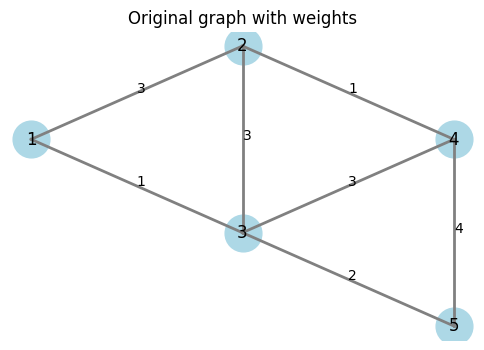

In [13]:
# Fixed positions for nodes 1..5
fixed_pos = {
    1: (-1.0,  0.5),
    2: ( 0.0,  1.0),
    3: ( 0.0,  0.0),
    4: ( 1.0,  0.5),
    5: ( 1.0, -0.5),
}

def draw_graph(G, pos, title="Graph"):
    """Draw G with node labels and edge weights using only matplotlib."""
    plt.figure(figsize=(6, 4))
    seen = set()

    # edges with weights
    for u in G:
        for v, w in G[u].items():
            if (v, u) in seen:
                continue
            x1, y1 = pos[u]
            x2, y2 = pos[v]
            plt.plot([x1, x2], [y1, y2], color="gray", linewidth=2)
            mx, my = (x1 + x2) / 2, (y1 + y2) / 2
            plt.text(mx, my, str(w), color="black", fontsize=10)
            seen.add((u, v))

    # nodes
    for u, (x, y) in pos.items():
        plt.scatter([x], [y], s=700, color="lightblue")
        plt.text(x, y, str(u), ha="center", va="center", fontsize=12)

    plt.title(title)
    plt.axis("off")
    plt.show()

draw_graph(G, fixed_pos, title="Original graph with weights")


In [14]:
def karger_min_cut_single_run(G_input):
    """
    One run of Karger's min-cut algorithm on adjacency dict G_input.
    Returns (cut_value, (S, T)).
    """
    # deep copy
    G = {u: dict(neighs) for u, neighs in G_input.items()}
    supernodes = {u: {u} for u in G_input}

    while len(G) > 2:
        # list edges with weights
        edges = []
        weights = []
        for u in G:
            for v, w in G[u].items():
                if u < v:
                    edges.append((u, v))
                    weights.append(w)

        if not edges:
            break  # degenerate case

        u, v = random.choices(edges, weights=weights, k=1)[0]

        # skip if this edge is no longer valid in the current contracted graph
        if u not in G or v not in G or u not in supernodes or v not in supernodes:
            continue
        if v not in G[u]:
            continue

        # merge v into u
        supernodes[u] |= supernodes[v]
        del supernodes[v]

        # rewire neighbors of v to u
        neighbors_v = list(G[v].items())
        for nbr, w in neighbors_v:
            if nbr == u:
                continue
            if nbr in G and v in G[nbr]:
                del G[nbr][v]
            if nbr not in G:
                continue
            if nbr in G[u]:
                G[u][nbr] += w
                G[nbr][u] += w
            else:
                G[u][nbr] = w
                G[nbr][u] = w

        # remove v from G
        if v in G:
            del G[v]
        if u in G and u in G[u]:
            del G[u][u]

    nodes = list(G.keys())
    if len(nodes) < 2:
        return 0, (set(), set())
    a, b = nodes[0], nodes[1]
    cut_value = G[a].get(b, 0)
    S = supernodes.get(a, set())
    T = supernodes.get(b, set())
    return cut_value, (S, T)


In [15]:
def run_karger_multiple_times(G, num_runs=100):
    """
    Run Karger num_runs times on the same graph G.
    Return list of dicts with run index, cut_value, S, T.
    """
    results = []
    for i in range(num_runs):
        cut_value, (S, T) = karger_min_cut_single_run(G)
        results.append({
            "run": i + 1,
            "cut_value": cut_value,
            "partition_S": S,
            "partition_T": T,
        })
        if (i + 1) % 20 == 0:
            print(f"Completed {i+1}/{num_runs} runs")
    return results

results = run_karger_multiple_times(G, num_runs=100)
print("Number of runs:", len(results))


Completed 20/100 runs
Completed 40/100 runs
Completed 60/100 runs
Completed 80/100 runs
Completed 100/100 runs
Number of runs: 100


In [16]:
csv_filename = "karger_results.csv"

with open(csv_filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["run", "cut_value", "partition_S", "partition_T"])
    for r in results:
        writer.writerow([r["run"], r["cut_value"], r["partition_S"], r["partition_T"]])

print("Results saved to", csv_filename)


Results saved to karger_results.csv


In [17]:
loaded_results = []
with open(csv_filename, "r", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        row["run"] = int(row["run"])
        row["cut_value"] = int(row["cut_value"])
        loaded_results.append(row)

cut_values = [r["cut_value"] for r in loaded_results]
best_cut = min(cut_values)
best_freq = sum(1 for v in cut_values if v == best_cut)

print("Best cut value:", best_cut)
print("Frequency of best cut:", best_freq, "out of", len(cut_values))


Best cut value: 4
Frequency of best cut: 36 out of 100


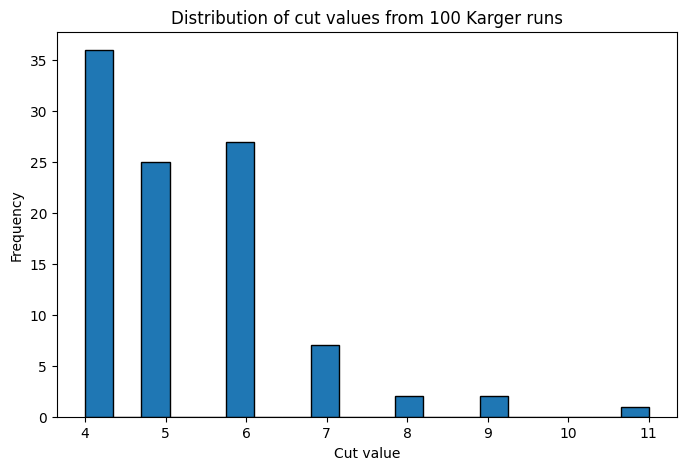

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(cut_values, bins=20, edgecolor="black")
plt.title("Distribution of cut values from 100 Karger runs")
plt.xlabel("Cut value")
plt.ylabel("Frequency")
plt.show()
